In [17]:
import sys, os, time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv
import util
import nltk

In [19]:
# nltk.pos_tag(tokens)

In [2]:
path = '../../../Downloads/aristo-tuple-kb-v5-mar2017/aristo.txt'

In [3]:
G = util.adict()
iG = util.adict()

In [4]:
with open(path, 'r') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for i, row in tqdm(enumerate(reader)):
        sub, rel, obj = row
        if sub not in G:
            G[sub] = util.adict()
        if rel not in G[sub]:
            G[sub][rel] = set()
        G[sub][rel].add(obj)
        if obj not in iG:
            iG[obj] = util.adict()
        if rel not in iG[obj]:
            iG[obj][rel] = set()
        iG[obj][rel].add(sub)

282594it [00:02, 127907.19it/s]


In [5]:
relations = set()
for sub, rels in G.items():
    relations.update(rels)
len(relations)

1605

In [6]:
outs = []
for sub, rels in G.items():
    outs.append(len(rels))
outs = np.array(outs)
outs.mean(), outs.std()

(3.6468053280148158, 10.542663062141266)

In [7]:
(outs > 1).sum() / len(outs)

0.39044803760951635

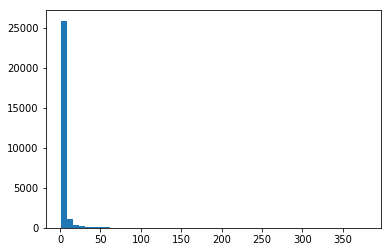

In [8]:
plt.hist(outs, bins=50)
pass

In [9]:
def _search(key, graph, tokens, threshold, fuel, root=[], collected=set()):
    if fuel == 0 or key not in graph:
        root.append(key)
        overlap = len(tokens.intersection(root))
        if overlap >= threshold:
            collected.add('\t'.join(root))
    else:

        fuel -= 1
        
        root.append(key)
        for rel in graph[key]:
            rroot = root.copy()
            rroot.append(rel)
            for obj in graph[key][rel]:
                if fuel > 0:
                    _search(obj, graph, tokens, threshold, 0, rroot.copy(), collected)
                _search(obj, graph, tokens, threshold, fuel, rroot.copy(), collected)

    return collected


def query(tokens, level=2, threshold=2, limit=50):
    out = []
    for sub in G:
        if sub in tokens:
            
            out.extend(_search(sub, G, tokens, threshold, level, root=[]))
            if len(out) > limit:
                return out
    return out

In [10]:
out = query({'food', 'plants', 'produce', 'future'}, level=2, threshold=2)
out = list(sorted(list(out), key=lambda x: len(x[1]), reverse=True))
len(out)

6968

In [11]:
ans = 'future'
for w in out:
    tokens = w.split('\t')
    if ans in tokens:
        print(tokens)
    else:
        for t in tokens:
            if ans in t:
                print('partial', tokens)

partial ['food', 'produce', 'plant', 'affect', 'future growth']


In [12]:
for w in out[:5]:
    print(w)

food	produce	effect	have	impact
food	produce	plant	have	branch habit
food	trigger	reaction	produce	wave
food	produce	energy	use	rechargeable battery
food	produce	plant	have	heart


In [155]:
'shape' in G.matter

False

In [107]:
for rel in G.matter:
    if 'shape' in G.matter[rel]:
        print('matter', rel, 'shape')

matter have shape


In [26]:
# Plants and animals need food for growth. What happens to most of the food that plants produce?
# A: food is released as gas
# B: food is converted to water
# C: food is stored for future use
# D: food is used to absorb sunlight

# The distance between Richmond and Norfolk is best measured in __.
# A: kilometers
# B: meters
# C: centimeters
# D: millimeters

# What state of matter has no definite volume and no definite shape?
# A: gas
# B: liquid
# C: solid

In [27]:
direct, sub_mat, obj_mat = query('state', 'matter', 'volume', 'shape')
direct, sub_mat, obj_mat

(['state', 'matter', 'volume', 'shape'], [], [])

In [36]:
def match_answers(qinfo, answers):
    matches = [[] for _ in answers]
    for q in qinfo:
        for m, a in zip(matches, answers):
            for r in G[q]:
                if a in G[q][r]:
                    m.append((q, r, a))
                
    return matches

In [37]:
match_answers(direct, ['gas', 'liquid', 'solid'])

[[], [('matter', 'become', 'liquid'), ('matter', 'exist as', 'liquid')], []]